# Adversarial Patch 

This document explains the purpose, structure, and usage of the code for generating an adversarial patch. The patch is optimized to fool a pre-trained ResNet34 model into predicting a chosen target class when the patch is applied to a background image (in this case, a bottle image).

## Run in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1MDOvuyG4V9Ornn67tr6DwwhTRkyF5OUy?usp=sharing)

## Overview
(Introduction below was generated by ChatGPT 4o on 03/03/ at 06:22pm for professional presentation)

The code performs the following tasks:

1. **Setup and Initialization**
2. **Patch and Mask Creation**
3. **Data Preparation**
4. **Training Loop**
5. **Saving the Result**

## Prerequisites

- **Python Packages:**
  - `torch`, `torchvision`, `numpy`, `PIL` and `google`
- **Environment:**
  - Google Colab (or any environment where you can mount Google Drive)
  - GPU access is recommended for faster training, although CPU is supported.

## Original Image

Classifed as 'Water Bottle' in Dr.Brent's resnet34 classfier

https://resnet34-classifier.streamlit.app/


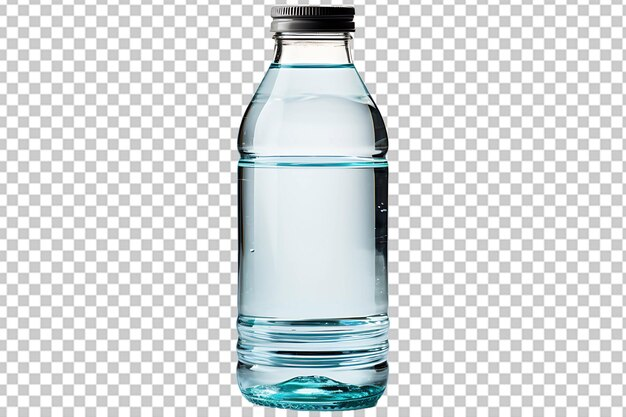

In [8]:
from PIL import Image
from IPython.display import display

image_path = r"C:\Users\Y\Desktop\Auto\my_bottle.jpg"
img = Image.open(image_path)
display(img)

In [13]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import numpy as np
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights='IMAGENET1K_V1').eval().to(device)
for param in model.parameters():
    param.requires_grad = False

# This was generated by ChatGPT 4o on 03/04/ at 9:14pm for faster production as its common to use 859 as target class for attacking resnet34.
target_class = 859
patch_size = 100
img_size = 224
margin = 20

# create_circular_mask function was generated by ChatGPT 4o on 03/04/ at 10:48am for better understanding on random masking techniques)
def create_circular_mask(h, w):
    center = (h // 2, w // 2)
    radius = min(center[0], center[1]) - 1
    Y, X = np.ogrid[:h, :w]
    dist = (X - center[1])**2 + (Y - center[0])**2
    mask = torch.from_numpy(dist <= radius**2).float().to(device)
    return mask

def tv_loss(x):
    return torch.mean(torch.abs(x[:, :, :-1] - x[:, :, 1:])) + torch.mean(torch.abs(x[:, :-1, :] - x[:, 1:, :]))

patch_mask = create_circular_mask(patch_size, patch_size)
patch = torch.randn((3, patch_size, patch_size), requires_grad=True, device=device)

optimizer = optim.Adam([patch], lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

num_epochs = 500
batch_size = 16

mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

image_path = r"C:\Users\Y\Desktop\Auto\my_bottle.jpg"
if os.path.exists(image_path):
    print("Image found!")
else:
    print("Image not found")
background_img = Image.open(image_path).convert("RGB")

bg_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(img_size),
    transforms.ToTensor()
])

for epoch in range(num_epochs):
    optimizer.zero_grad()
    background_list = []
    for _ in range(batch_size):
        background_list.append(bg_transform(background_img))
    background = torch.stack(background_list).to(device)
    
    current_patch = torch.sigmoid(patch)
    
    angle = torch.FloatTensor(1).uniform_(-30, 30).to(device)
    transformed_patch = TF.rotate(current_patch.unsqueeze(0), angle.item()).squeeze(0)
    
    scale = torch.FloatTensor(1).uniform_(0.8, 1.2).to(device)
    scaled_size = int(patch_size * scale.item())
    transformed_patch = TF.resize(
        transformed_patch.unsqueeze(0),
        (scaled_size, scaled_size)
    ).squeeze(0)
    
    if scaled_size < patch_size:
        pad = (patch_size - scaled_size) // 2
        transformed_patch = TF.pad(
            transformed_patch,
            [pad, pad,
             pad + (patch_size - scaled_size - 2*pad),
             pad + (patch_size - scaled_size - 2*pad)]
        )
    else:
        transformed_patch = TF.center_crop(transformed_patch, (patch_size, patch_size))
    
    transformed_patch = transformed_patch * patch_mask
    
    # This was generated by ChatGPT 4o on 03/04/ at 12:03pm for improvement suggestions(brightness & contrast, flipping horizontally) on the model to make it more robust.
    transformed_patch = TF.adjust_brightness(
        transformed_patch, torch.FloatTensor(1).uniform_(0.8, 1.2).item()
    )
    transformed_patch = TF.adjust_contrast(
        transformed_patch, torch.FloatTensor(1).uniform_(0.8, 1.2).item()
    )
    if torch.rand(1).item() > 0.5:
        transformed_patch = TF.hflip(transformed_patch)
    
    patched_images = []
    for i in range(batch_size):
        x = torch.randint(margin, img_size - patch_size - margin, (1,)).item()
        y = torch.randint(margin, img_size - patch_size - margin, (1,)).item()
        img = background[i].clone()
        img[:, y:y+patch_size, x:x+patch_size] = (
            img[:, y:y+patch_size, x:x+patch_size] * (1 - patch_mask) 
            + transformed_patch
        )
        patched_images.append(img)
    
    patched_images = torch.stack(patched_images)
    
    normalized = (patched_images - mean) / std
    outputs = model(normalized)
    classification_loss = -torch.nn.functional.log_softmax(outputs, dim=1)[:, target_class].mean()
    
    alpha = 0.1
    loss = classification_loss + alpha * tv_loss(current_patch.unsqueeze(0))
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

final_patch = torch.sigmoid(patch).detach().cpu()
final_patch_pil = TF.to_pil_image(final_patch)
final_patch_pil.save('adversarial.png')
print("Training complete. Saved as 'adversarial.png'.")


Image found!
Epoch 0, Loss: 14.9049
Epoch 50, Loss: 13.7779
Epoch 100, Loss: 11.8750
Epoch 150, Loss: 11.0324
Epoch 200, Loss: 10.3367
Epoch 250, Loss: 11.2839
Epoch 300, Loss: 9.7839
Epoch 350, Loss: 10.2946
Epoch 400, Loss: 11.1823
Epoch 450, Loss: 10.3324
Training complete. Saved as 'adversarial.png'.


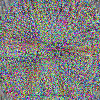

In [9]:
image_path = r"C:\Users\Y\Desktop\Auto\adversarial_sticker.png"
img = Image.open(image_path)
display(img)

## After-Attack Image

This is an adversarial image after the attack. And it classfied as 'dishcloth' in Dr.Brent's resnet34 classfier

https://resnet34-classifier.streamlit.app/

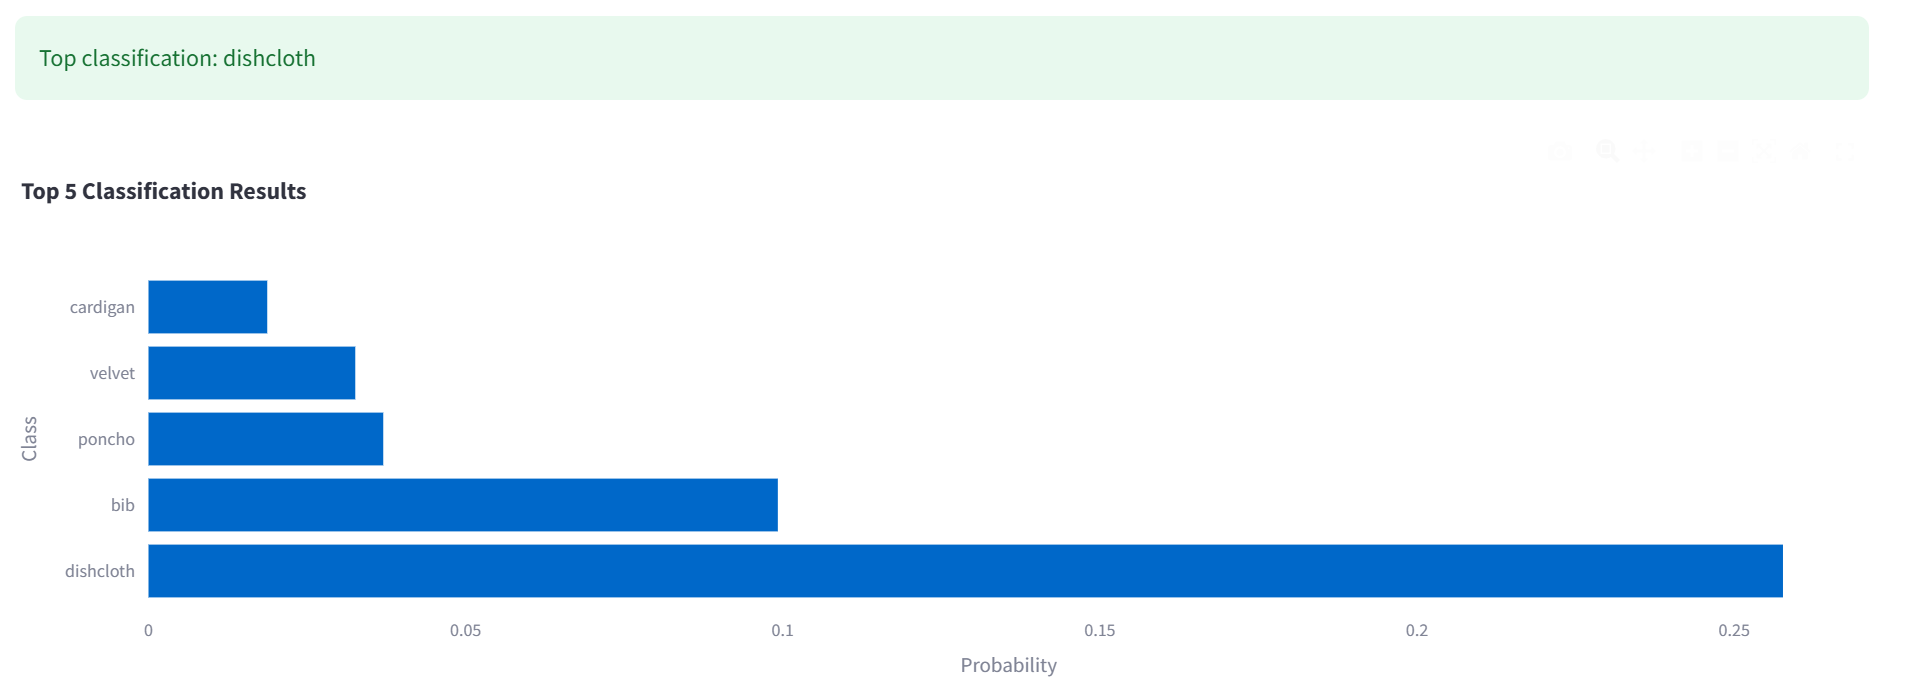

In [10]:
image_path = r"C:\Users\Y\Desktop\Auto\after_attack.png"
img = Image.open(image_path)
display(img)

## Patching

Below is the code for patching, and the process are:

1. **Load the Pretrained Model (ResNet34)**
2. **Define Image Transforms and Sizes into 80x80**
3. **Load & Convert Images to Tensors**
4. **Create a Circular Mask**
5. **Blend the Patch onto the Image**
6. **Normalize & Classify**f

I also make the image more transparent for better classification

In [ ]:
import cv2
import torch.nn.functional as F

def create_circular_mask(h, w):
    center = (h // 2, w // 2)
    radius = min(center)
    Y, X   = np.ogrid[:h, :w]
    dist   = (X - center[1])**2 + (Y - center[0])**2
    mask   = (dist <= radius**2).astype(np.float32)
    return torch.from_numpy(mask)

img_size = 224
patch_size = 80
alpha = 0.3

bg_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

patch_transform = transforms.Compose([
    transforms.Resize((patch_size, patch_size)),
    transforms.ToTensor()
])

background_image_path = r"C:\Users\Y\Desktop\Auto\my_bottle.jpg"
patch_image_path      = r"C:\Users\Y\Desktop\Auto\adversarial_sticker.png"
background_pil = Image.open(background_image_path).convert("RGB")
patch_pil      = Image.open(patch_image_path).convert("RGB")
background_tensor = bg_transform(background_pil).unsqueeze(0).to(device)
patch_tensor      = patch_transform(patch_pil).unsqueeze(0).to(device)
patch_mask = create_circular_mask(patch_size, patch_size).unsqueeze(0).to(device)

x_offset, y_offset = 10, 10
patched_image_tensor = background_tensor.clone()

bg_region = patched_image_tensor[:, :,
    y_offset : y_offset + patch_size,
    x_offset : x_offset + patch_size
]

blended_region = (
    bg_region * (1 - alpha * patch_mask)
    + patch_tensor * (alpha * patch_mask)
)

patched_image_tensor[:, :,
    y_offset : y_offset + patch_size,
    x_offset : x_offset + patch_size
] = blended_region

mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
patched_norm = (patched_image_tensor - mean) / std
with torch.no_grad():
    outputs = model(patched_norm)
    probs   = F.softmax(outputs, dim=1)
    top5    = torch.topk(probs, 5, dim=1)

patched_np = (
    patched_image_tensor.squeeze().permute(1,2,0).cpu().numpy().clip(0,1)*255
).astype(np.uint8)
patched_bgr = cv2.cvtColor(patched_np, cv2.COLOR_RGB2BGR)
cv2.imwrite("patched_bottle.png", patched_bgr)
print("Patched image saved as 'patched_bottle.png'.")


Patched image saved as 'patched_bottle.png'.


## Results after patching

Below is the images of the patched and the result from Dr.Brent's resnet34-classifier, which successfully classifed the object as 'Water Bottle' from 'discloth' indicating a working sample for the adversarial patch

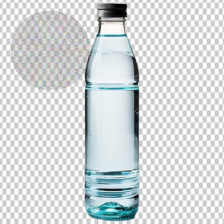

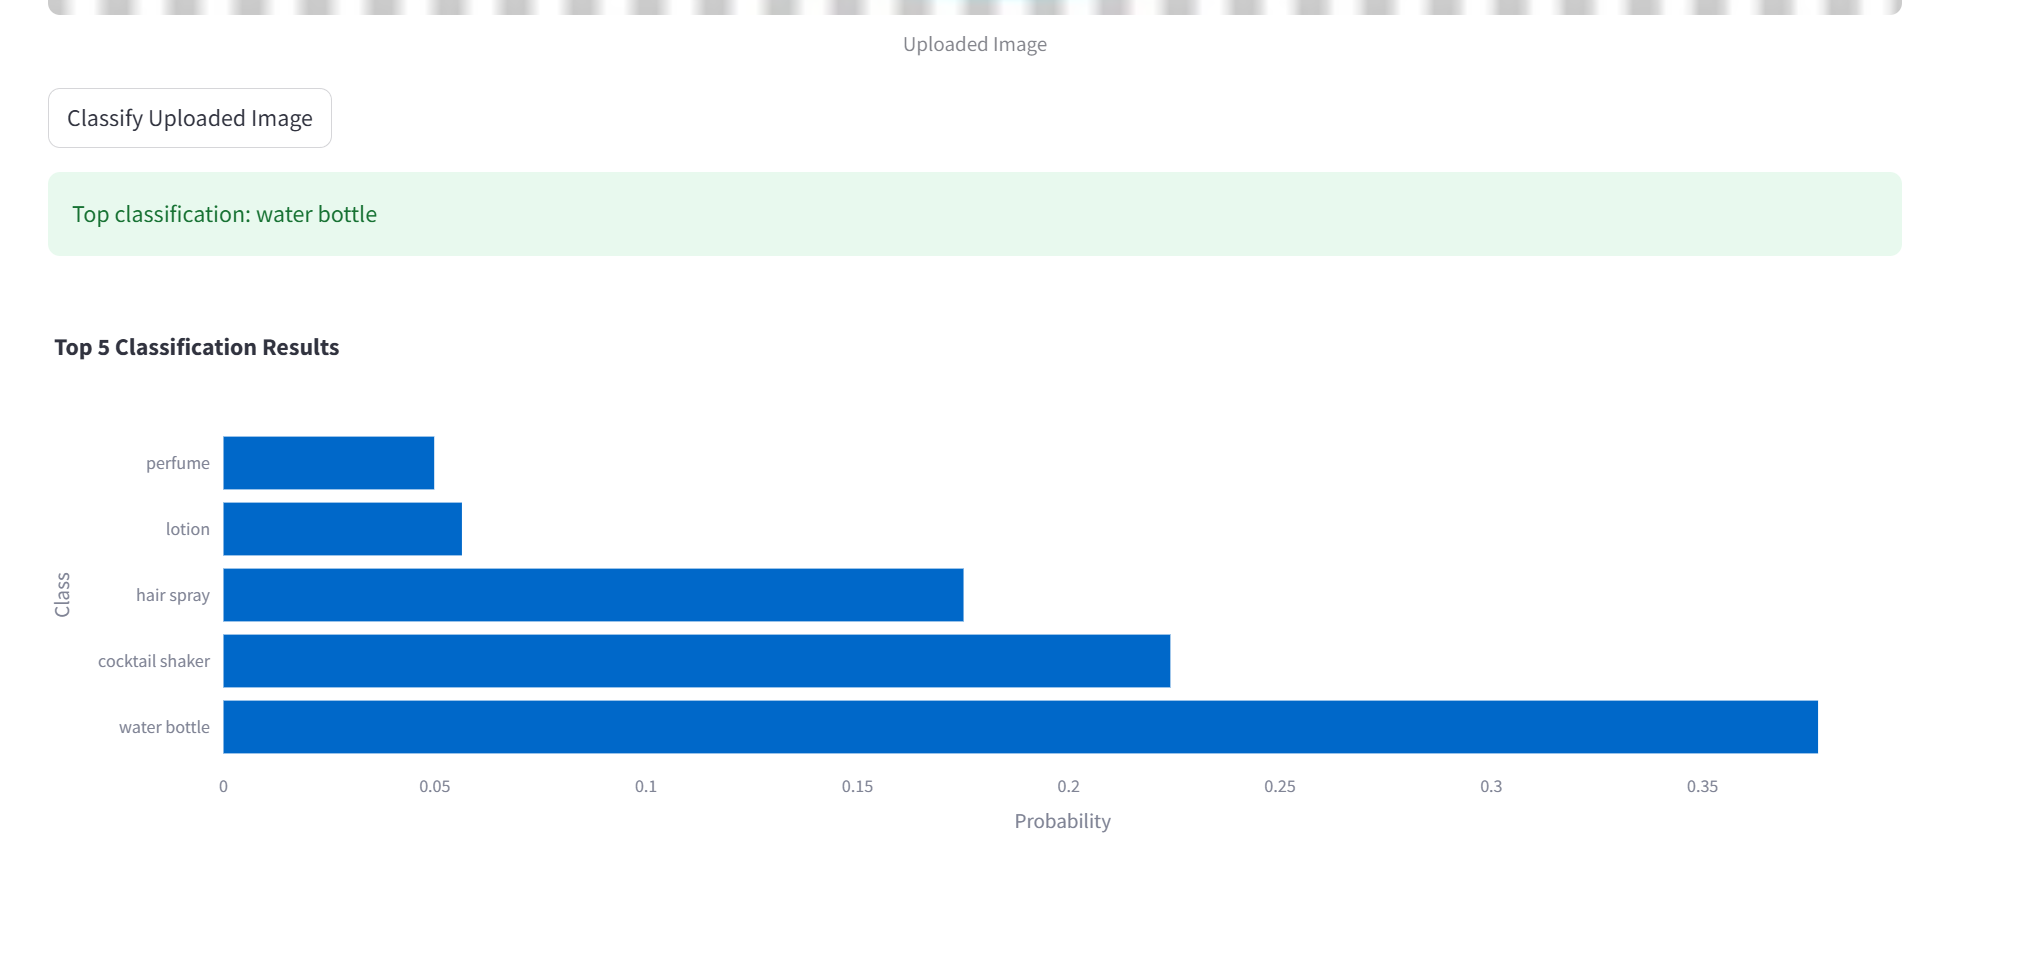

In [11]:
image_path = r"C:\Users\Y\Desktop\Auto\patched_bottle.png"
img = Image.open(image_path)
display(img)

image_path = r"C:\Users\Y\Desktop\Auto\resnet34-classifier.png"
img = Image.open(image_path)
display(img)